# Machine Learning for Networking 
# Group Project 5 - DDoS attacks detection and characterization - Section 1
# Preliminary operations

In [3]:
# import needed python libraries

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
# load dataset
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",", dtype={'SimillarHTTP': str})
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
columns = ddos_data.columns

In [5]:
ddos_data

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64235,65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64236,65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64237,65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


# Investigate the provided dataset

***From the specifications***: *"Flow ID: a unique identifier for each flow of network traffic in the dataset"*<br>
***Question***: Is a Flow ID unique or can it be repeated?

In [6]:
ddos_data["Flow ID"].value_counts()

172.16.0.5-192.168.50.1-0-0-0             18
192.168.50.253-224.0.0.5-0-0-0            14
192.168.50.254-224.0.0.5-0-0-0            14
8.0.6.4-8.6.0.1-0-0-0                     12
172.16.0.5-192.168.50.1-9553-22-6          9
                                          ..
172.16.0.5-192.168.50.1-36404-21981-17     1
172.16.0.5-192.168.50.1-36405-46365-17     1
172.16.0.5-192.168.50.1-61850-24027-17     1
172.16.0.5-192.168.50.1-61850-6932-17      1
172.16.0.5-192.168.50.1-45602-1387-17      1
Name: Flow ID, Length: 60958, dtype: int64

**Watch out:** <br>While analyzing the provided dataset, we encountered an error related to data quality issues, specifically that the flow ID sometimes does not adhere to the standard format. As a result of this, We deemed it necessary to remove the current flow ID and generate a new one of our own.
* Flow ID is the combination of: source IP - destination ip - source port - destination port - protocol

In [7]:
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' + 
                         ddos_data['Destination Port'].astype(str) ) 
ddos_data["Flow ID"].value_counts()

172.16.0.5 - 0 - 192.168.50.1 - 0            18
192.168.50.253 - 0 - 224.0.0.5 - 0           14
192.168.50.254 - 0 - 224.0.0.5 - 0           14
8.6.0.1 - 0 - 8.0.6.4 - 0                    12
192.168.50.7 - 50107 - 52.173.24.17 - 443     9
                                             ..
172.16.0.5 - 36603 - 192.168.50.1 - 44950     1
172.16.0.5 - 36604 - 192.168.50.1 - 9261      1
172.16.0.5 - 36605 - 192.168.50.1 - 3322      1
172.16.0.5 - 36606 - 192.168.50.1 - 3631      1
172.16.0.5 - 45602 - 192.168.50.1 - 1387      1
Name: Flow ID, Length: 62154, dtype: int64

We expected a flow ID to be unique, but indeed, a certain flow can be repeated. Let's consider an individual accessing a service daily; each day, the flow ID remains the same. What we expect to be unique for each sample is the combination: Flow ID + Timestamp.

In [8]:
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' + 
                         ddos_data['Destination Port'].astype(str) + ' - ' + 
                         ddos_data['Timestamp'].astype(str) ) 

# By running this instruction ( and commenting on the next one) you can see that Flow ID + Timestamp are unique
# ddos_data["Flow ID"].value_counts()
ddos_data = ddos_data.set_index("Flow ID")

***Our hypothesis is correct.***

Cleaning features that do not provide information and can be removed:
* Numerical Index Unnamed 

Identified categorical features
* Simillar HTTP

In [9]:
ddos_data.drop("Unnamed: 0", axis=1, inplace=True)

ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].astype(str).str.strip()
ddos_data['SimillarHTTP'] = pd.Categorical(ddos_data['SimillarHTTP']).codes


We notice that many columns have the same value 0 for all samples, therefore they have zero variance and can be eliminated because they do not provide any information.

In [10]:
# Variance for each column
variance = ddos_data.var(numeric_only=True)

# Find columns with zero variance
zero_variance = variance[variance == 0].index

# Remove these columns from the DataFrame
ddos_data.drop(zero_variance, axis=1, inplace=True)
ddos_data

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
Flow ID,,,,,,,,,,,,,,,,,,,,,
172.16.0.5 - 634 - 192.168.50.1 - 60495 - 2018-12-01 10:51:39.813448,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,42680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
192.168.50.1 - 634 - 172.16.0.5 - 60495 - 2018-12-01 10:51:39.820842,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,880.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
172.16.0.5 - 634 - 192.168.50.1 - 46391 - 2018-12-01 10:51:39.852499,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,88000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
172.16.0.5 - 634 - 192.168.50.1 - 11894 - 2018-12-01 10:51:39.890213,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,88000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
172.16.0.5 - 634 - 192.168.50.1 - 27878 - 2018-12-01 10:51:39.941151,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,88000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172.16.0.5 - 38625 - 192.168.50.1 - 63051 - 2018-12-01 13:04:46.628249,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
172.16.0.5 - 58632 - 192.168.50.1 - 18963 - 2018-12-01 13:04:46.628963,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,2088.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
172.16.0.5 - 46104 - 192.168.50.1 - 64704 - 2018-12-01 13:04:46.629014,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


 # Visualizations and statistical analysis

### Generic traffic level

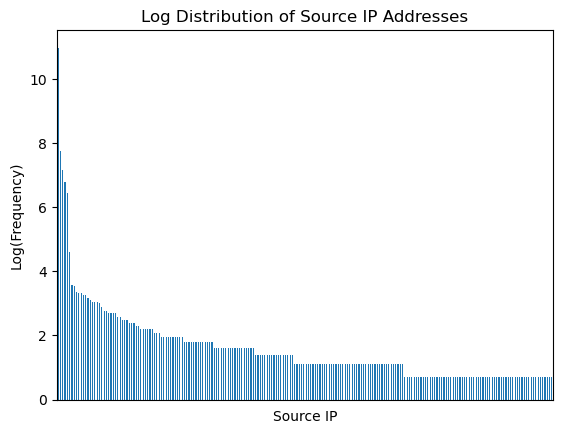

In [11]:
source_ip_count = ddos_data['Source IP'].value_counts()

# Add 1 before log transformation to avoid log(0)
source_ip_count_log = np.log(source_ip_count + 1)

source_ip_count_log.plot(kind='bar')
plt.title('Log Distribution of Source IP Addresses')
plt.xlabel('Source IP')
plt.xticks([])  # Hides x labels
plt.ylabel('Log(Frequency)')
plt.show()

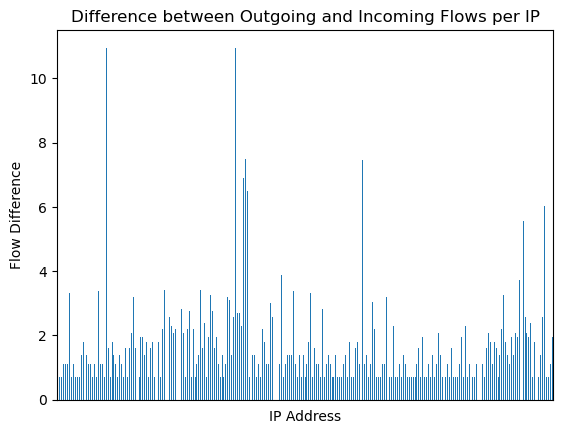

In [12]:
incoming_flows = ddos_data['Destination IP'].value_counts()
outgoing_flows = ddos_data['Source IP'].value_counts()
flow_difference = outgoing_flows.subtract(incoming_flows, fill_value=0)
flow_difference_log = np.log(flow_difference.abs()+1)

flow_difference_log.plot(kind='bar')
plt.title('Difference between Outgoing and Incoming Flows per IP')
plt.xlabel('IP Address')
plt.xticks([]) 
plt.ylabel('Flow Difference')
plt.show()

**ECDF of ports**

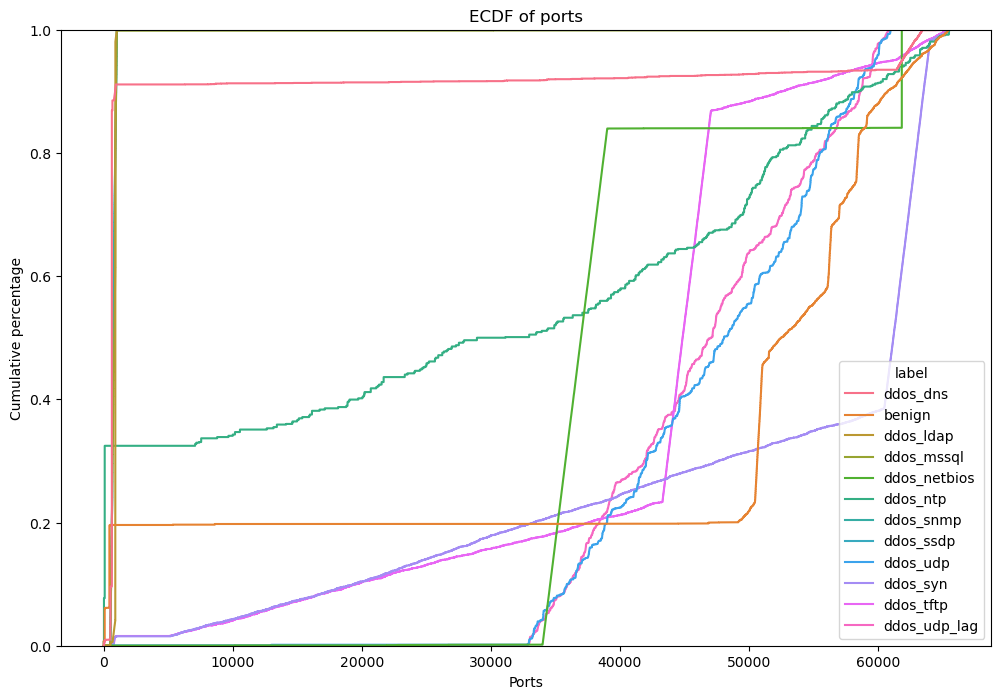

In [13]:
plt.figure(figsize=(12, 8))
sns.ecdfplot(x='Source Port', data=ddos_data, hue='label')
plt.title('ECDF of ports')
plt.xlabel('Ports')
plt.ylabel('Cumulative percentage')
plt.show()

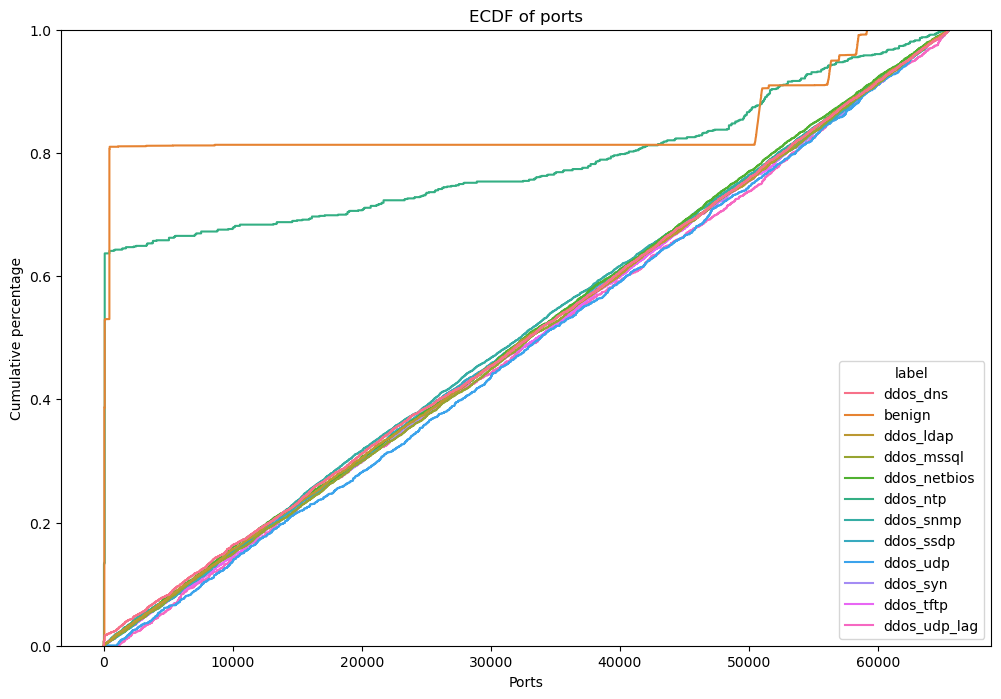

In [14]:
plt.figure(figsize=(12, 8))
sns.ecdfplot(x='Destination Port', data=ddos_data, hue='label')
plt.title('ECDF of ports')
plt.xlabel('Ports')
plt.ylabel('Cumulative percentage')
plt.show()

### Ground truth  level

**Number of flows for each attack class**

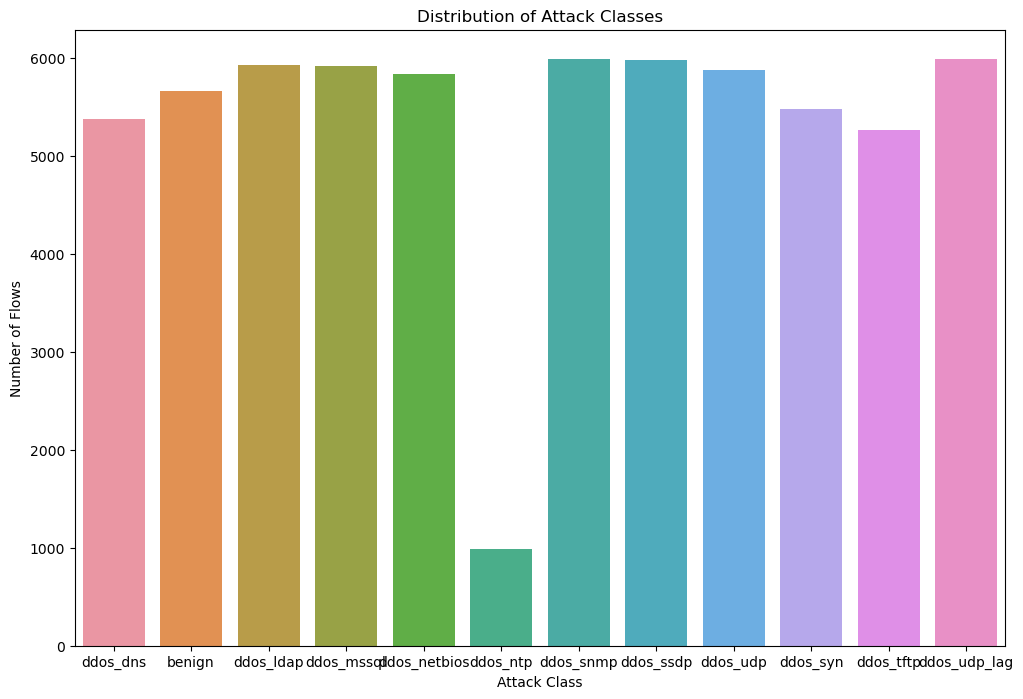

In [15]:
plt.figure(figsize=(12, 8))
sns.countplot(x="label", data=ddos_data)
plt.title("Distribution of Attack Classes")
plt.xlabel("Attack Class")
plt.ylabel("Number of Flows")
plt.show()


**Flow duration in relation to attack**

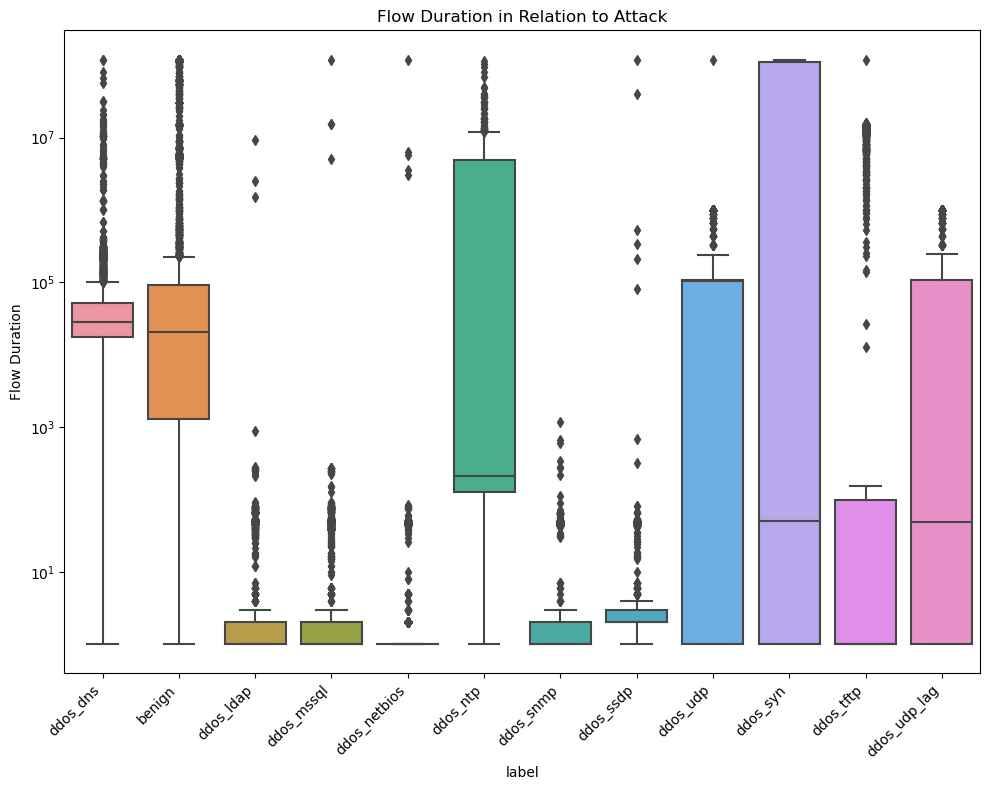

In [16]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=ddos_data, x='label', y='Flow Duration')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # Rotate the labels
ax.set_yscale('log')  # Set logarithmic scale on the y-axis
ax.set_title('Flow Duration in Relation to Attack')
plt.tight_layout()  # Ensure nothing is cut off
plt.show()


**Distribution of ports according to attack type**

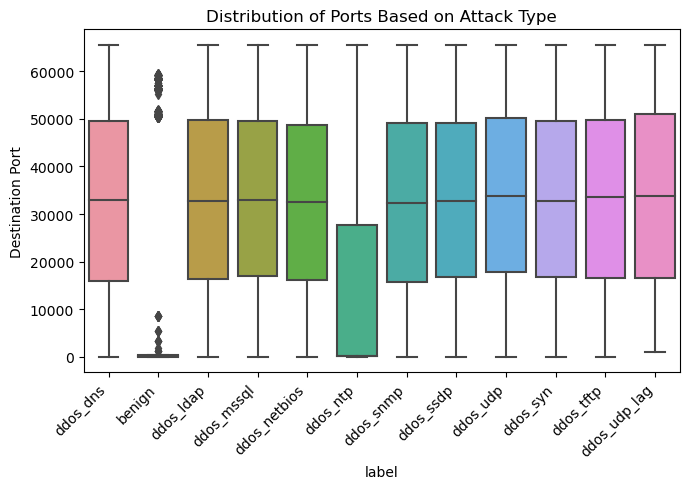

In [17]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Destination Port')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Distribution of Ports Based on Attack Type')
plt.tight_layout()
plt.show()


**Flow duration according to attack type**

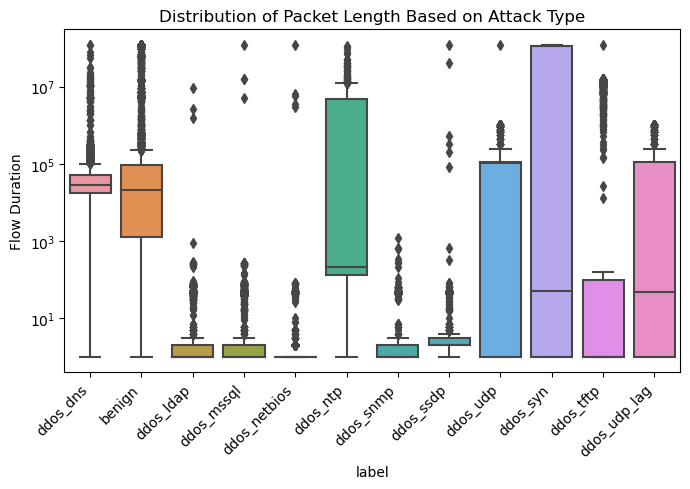

In [18]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Flow Duration')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Distribution of Packet Length Based on Attack Type')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

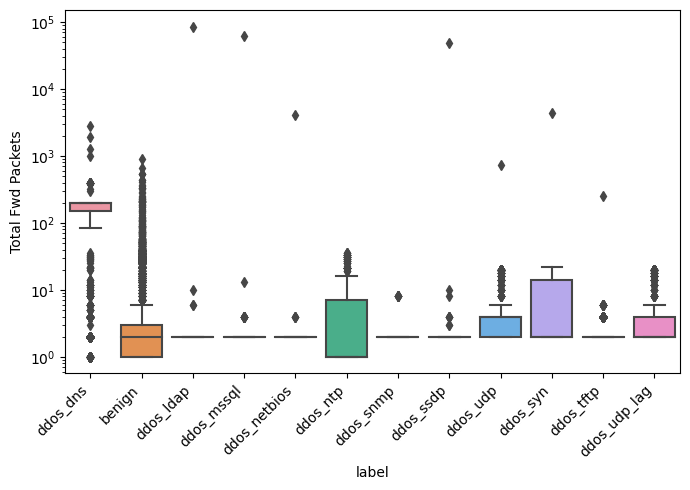

In [19]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Total Fwd Packets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

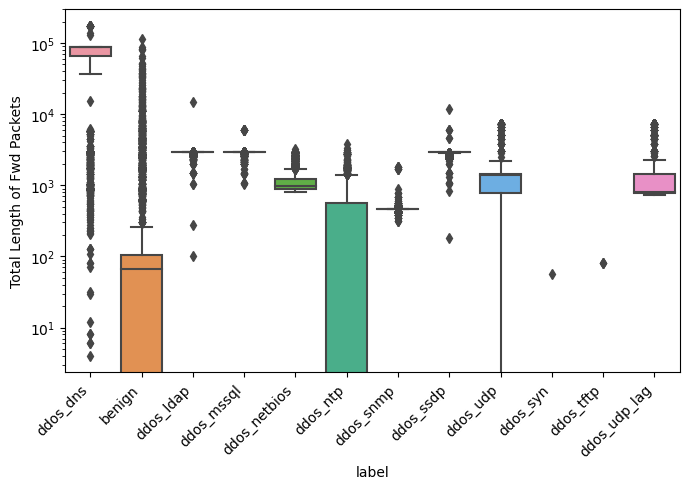

In [20]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Total Length of Fwd Packets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yscale('log', base=10)
plt.tight_layout()
plt.show()

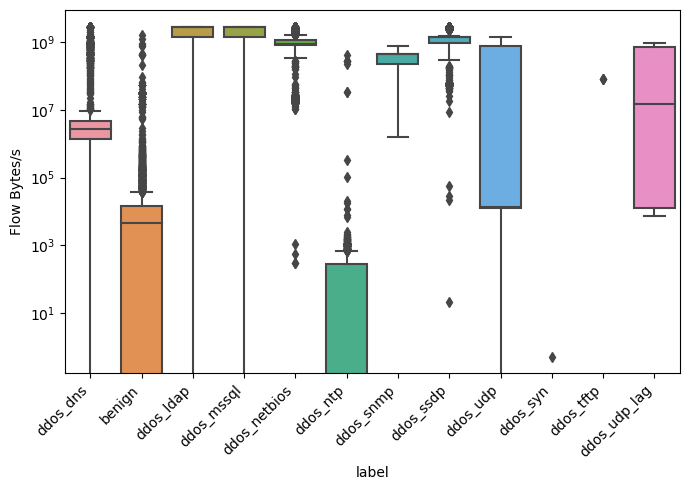

In [21]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Flow Bytes/s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yscale('log', base=10)
plt.tight_layout()
plt.show()

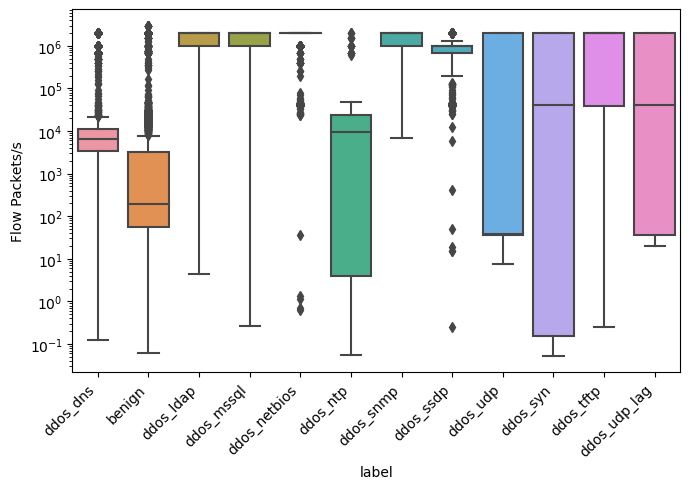

In [22]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Flow Packets/s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yscale('log', base=10)
plt.tight_layout()
plt.show()

**ECDF (Empirical Cumulative Distribution Function) of the total duration of fwd packets**<br>
(the total length, in bytes, of the packets sent from the source to the destination), useful for understanding how the majority of attacks utilize almost 100% the same packet size, while others (such as ddos_dns) employ packets of significantly different and variable sizes. (**MOTIVATION**: During a DDoS attack on DNS, attackers can generate a variety of DNS queries, each with different packet length requirements. 
For instance, legitimate domain names, random strings, or invalid characters may be included in an attempt to exploit 
vulnerabilities in the target DNS server.)

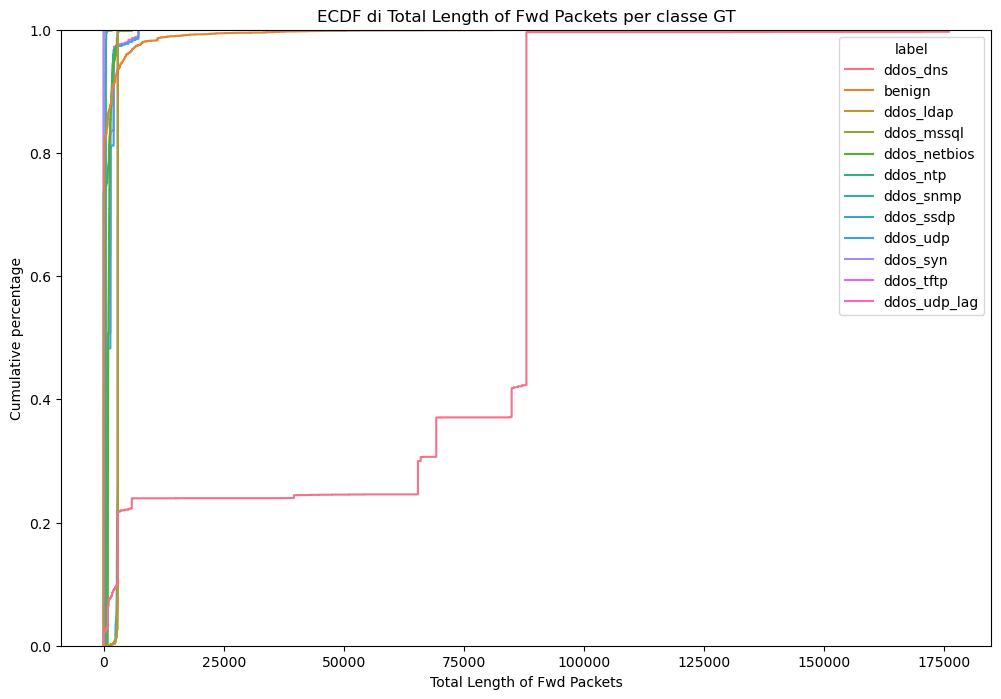

In [23]:
plt.figure(figsize=(12, 8))
sns.ecdfplot(x='Total Length of Fwd Packets', data=ddos_data, hue='label')
plt.title('ECDF di Total Length of Fwd Packets per classe GT')
plt.xlabel('Total Length of Fwd Packets')
plt.ylabel('Cumulative percentage')
plt.show()

First conclusions drawn, many features already have mean, deviation, minimum and maximum, we only need to add a few features

### PCA

Abbiamo scelto di seguire la seguente strategia:
1)  eseguire la PCA sull'intero dataset
2)  calolcare la matrice di correlazione con coefficente di pearson
3)  calcolare la matrice di correlazione con coefficente di spearman
4)  valutare i risultati evinti da loading score e dai coefficenti per scegliere le features da eliminare

Abbiamo provato entrambi i coefficenti di correlazione perchè non sappiamo se ci troveremo di fronte a relazioni lineari o non lineari, quindi vogliamo cercare di essere il più generici possibili per ora ed esplorare entrambe le vie.

Siamo consapevoli che questo renderà la PCA meno efficace nel ridurre la dimensionalità visto che il dataset include molte features altamente correlate, ma questo ci assicura di non eliminare subito features che, nonostante l'alta correlazione, sono critiche per catturare aspetti unici dei dati.

#### Standardization of data

In [34]:
# Create a copy of the original ddos_data DataFrame to preserve the original data
ddos_data_copy = ddos_data.copy()

# Drop non-numeric and non-essential columns from the copied DataFrame
ddos_data_copy.drop(
    columns=["Destination IP", "Source IP", "Source Port", "Destination Port", "Timestamp", "Protocol", "label"], 
    axis=1, 
    inplace=True)

# Initialize the StandardScaler
scaler = StandardScaler()

# Compute the mean and standard deviation to be used for later scaling of the data
scaler.fit(ddos_data_copy)

# Perform standardization by centering and scaling the data
features_tmp = scaler.transform(ddos_data_copy)

# Create a new DataFrame using the scaled data, preserving the original column names
ddos_data_s = pd.DataFrame(features_tmp, columns=ddos_data_copy.columns)

#### PCA computation and visualization

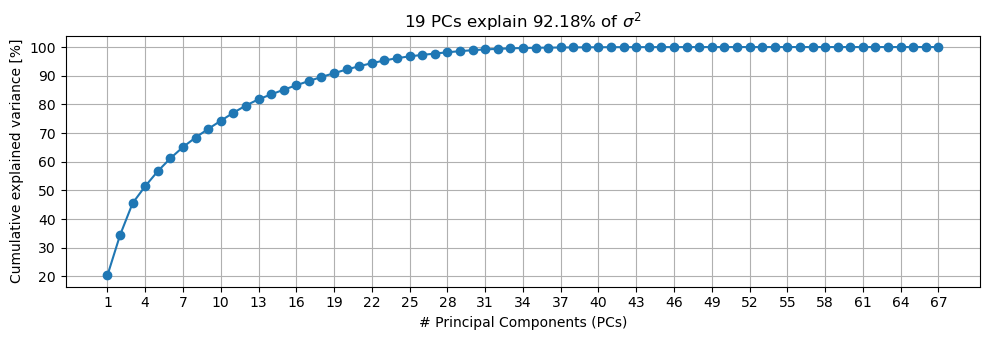

In [35]:
# Initialize PCA with a set random state for reproducibility
pca = PCA(random_state=15)
# Fit the PCA model to the ddos_data_x dataset to determine the principal components
pca.fit(ddos_data_s)
# Retrieve the explained variance ratio of each principal component
explained_variance = pca.explained_variance_ratio_
# Calculate the cumulative explained variance across all principal components
cumul_exp_var = np.cumsum(explained_variance)
# Convert the cumulative explained variance to percentage format
perc_cumul_exp_var = cumul_exp_var * 100


# Plot the cumulative explained variance percentage as a function of the number of principal components
plt.figure(figsize=(10, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks(np.arange(0, 67, 3), np.arange(1, 68, 3))
plt.grid()
plt.title(f'19 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\\sigma^2$')
plt.tight_layout()
plt.show()


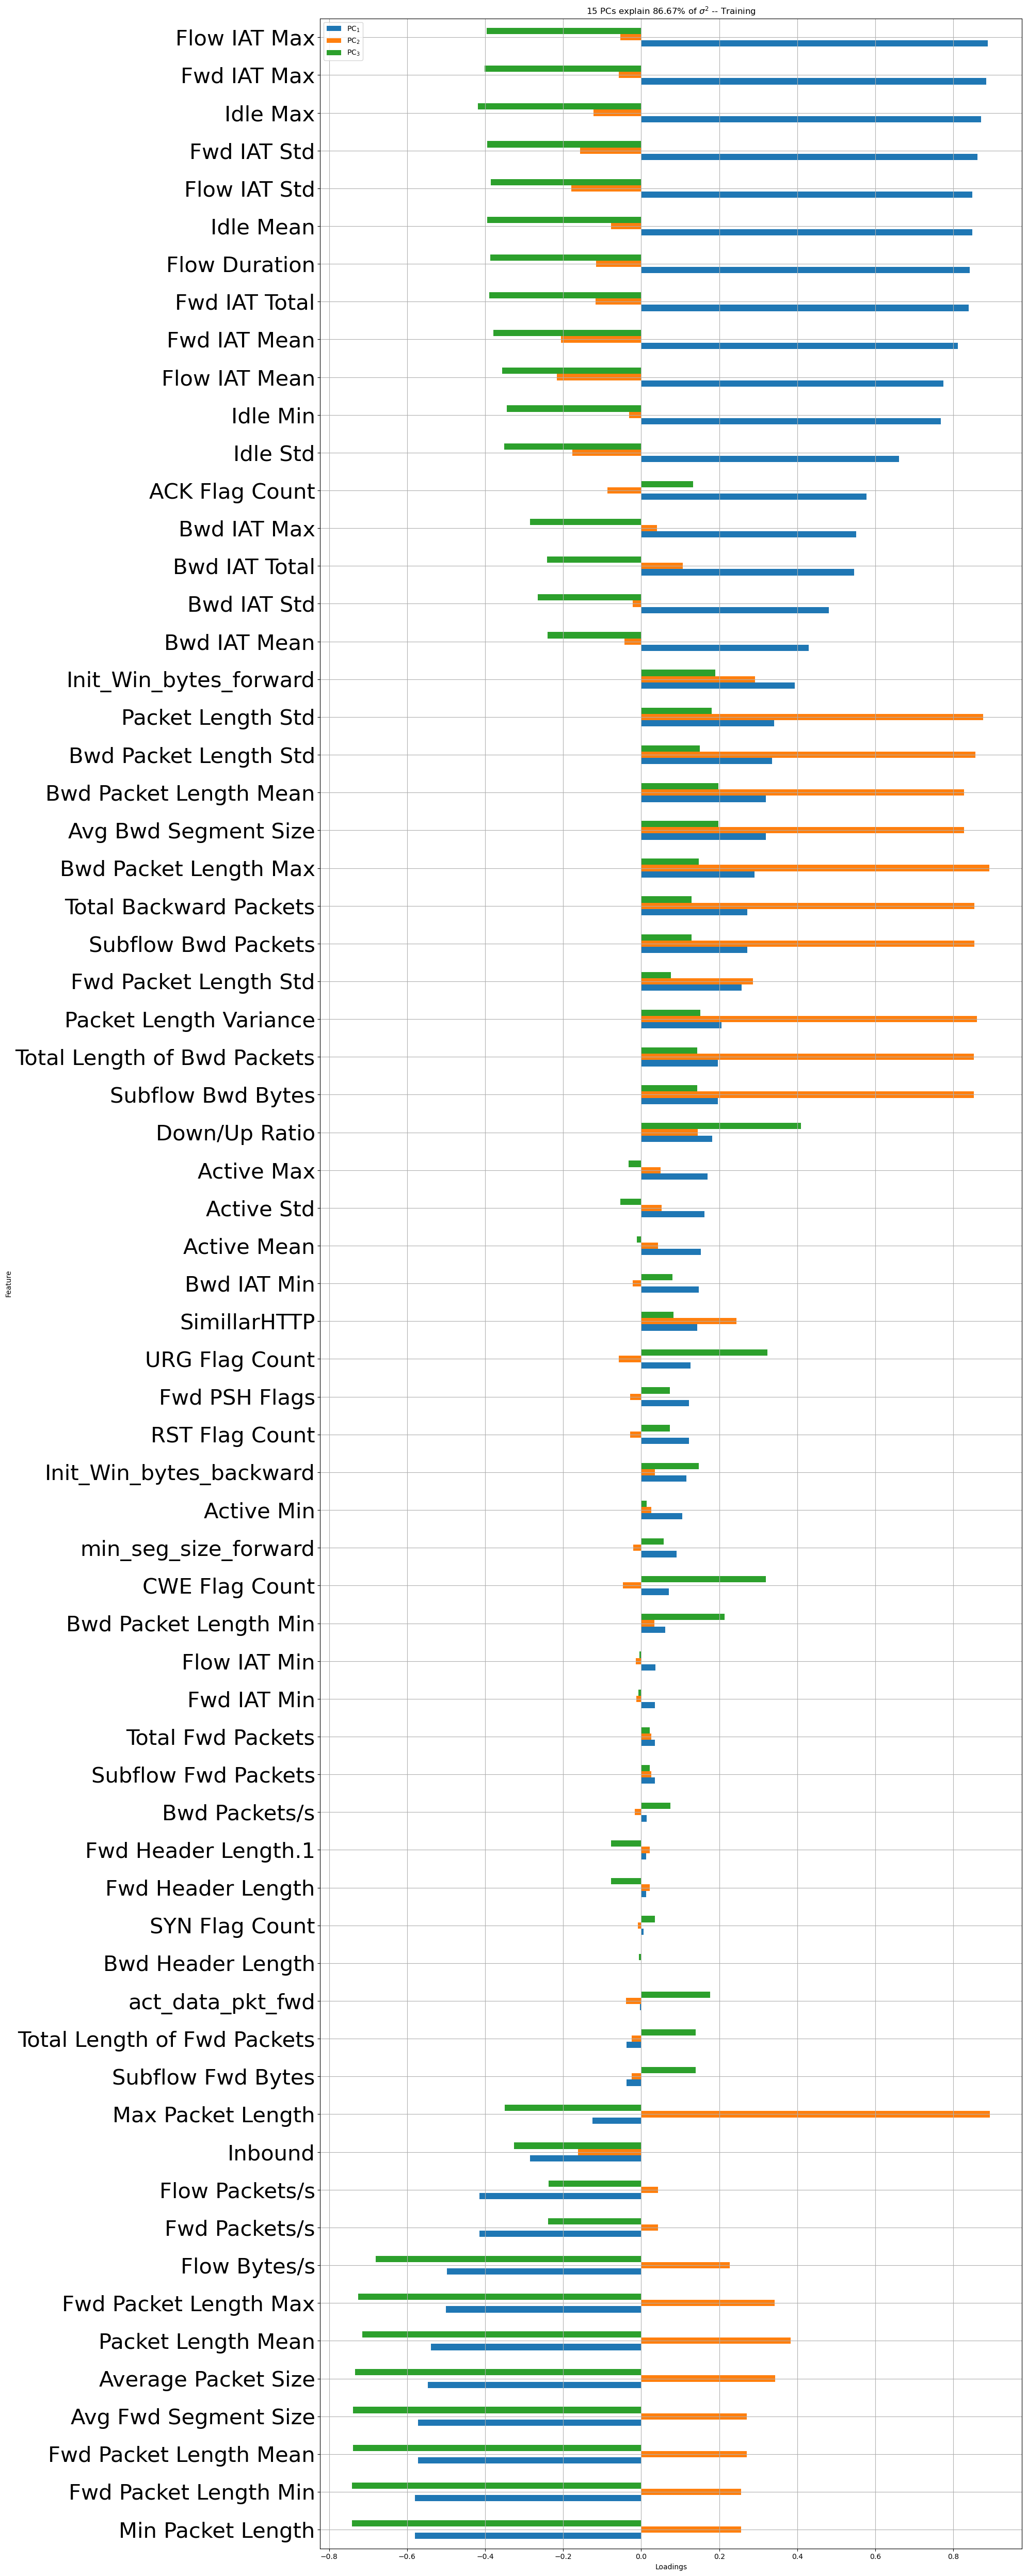

In [53]:
# Compute the loading scores
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 68)],
    index = ddos_data_s.columns
)

plt.figure(figsize=(20, 50))
loadings = loadings[['PC1', 'PC2', 'PC3']]
loadings.sort_values(['PC1', 'PC2', 'PC3']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$', 'PC3':'PC$_{3}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.yticks(fontsize=30)
plt.title(f'19 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$ -- Training')
plt.tight_layout()
plt.show()

### Correlation analysis

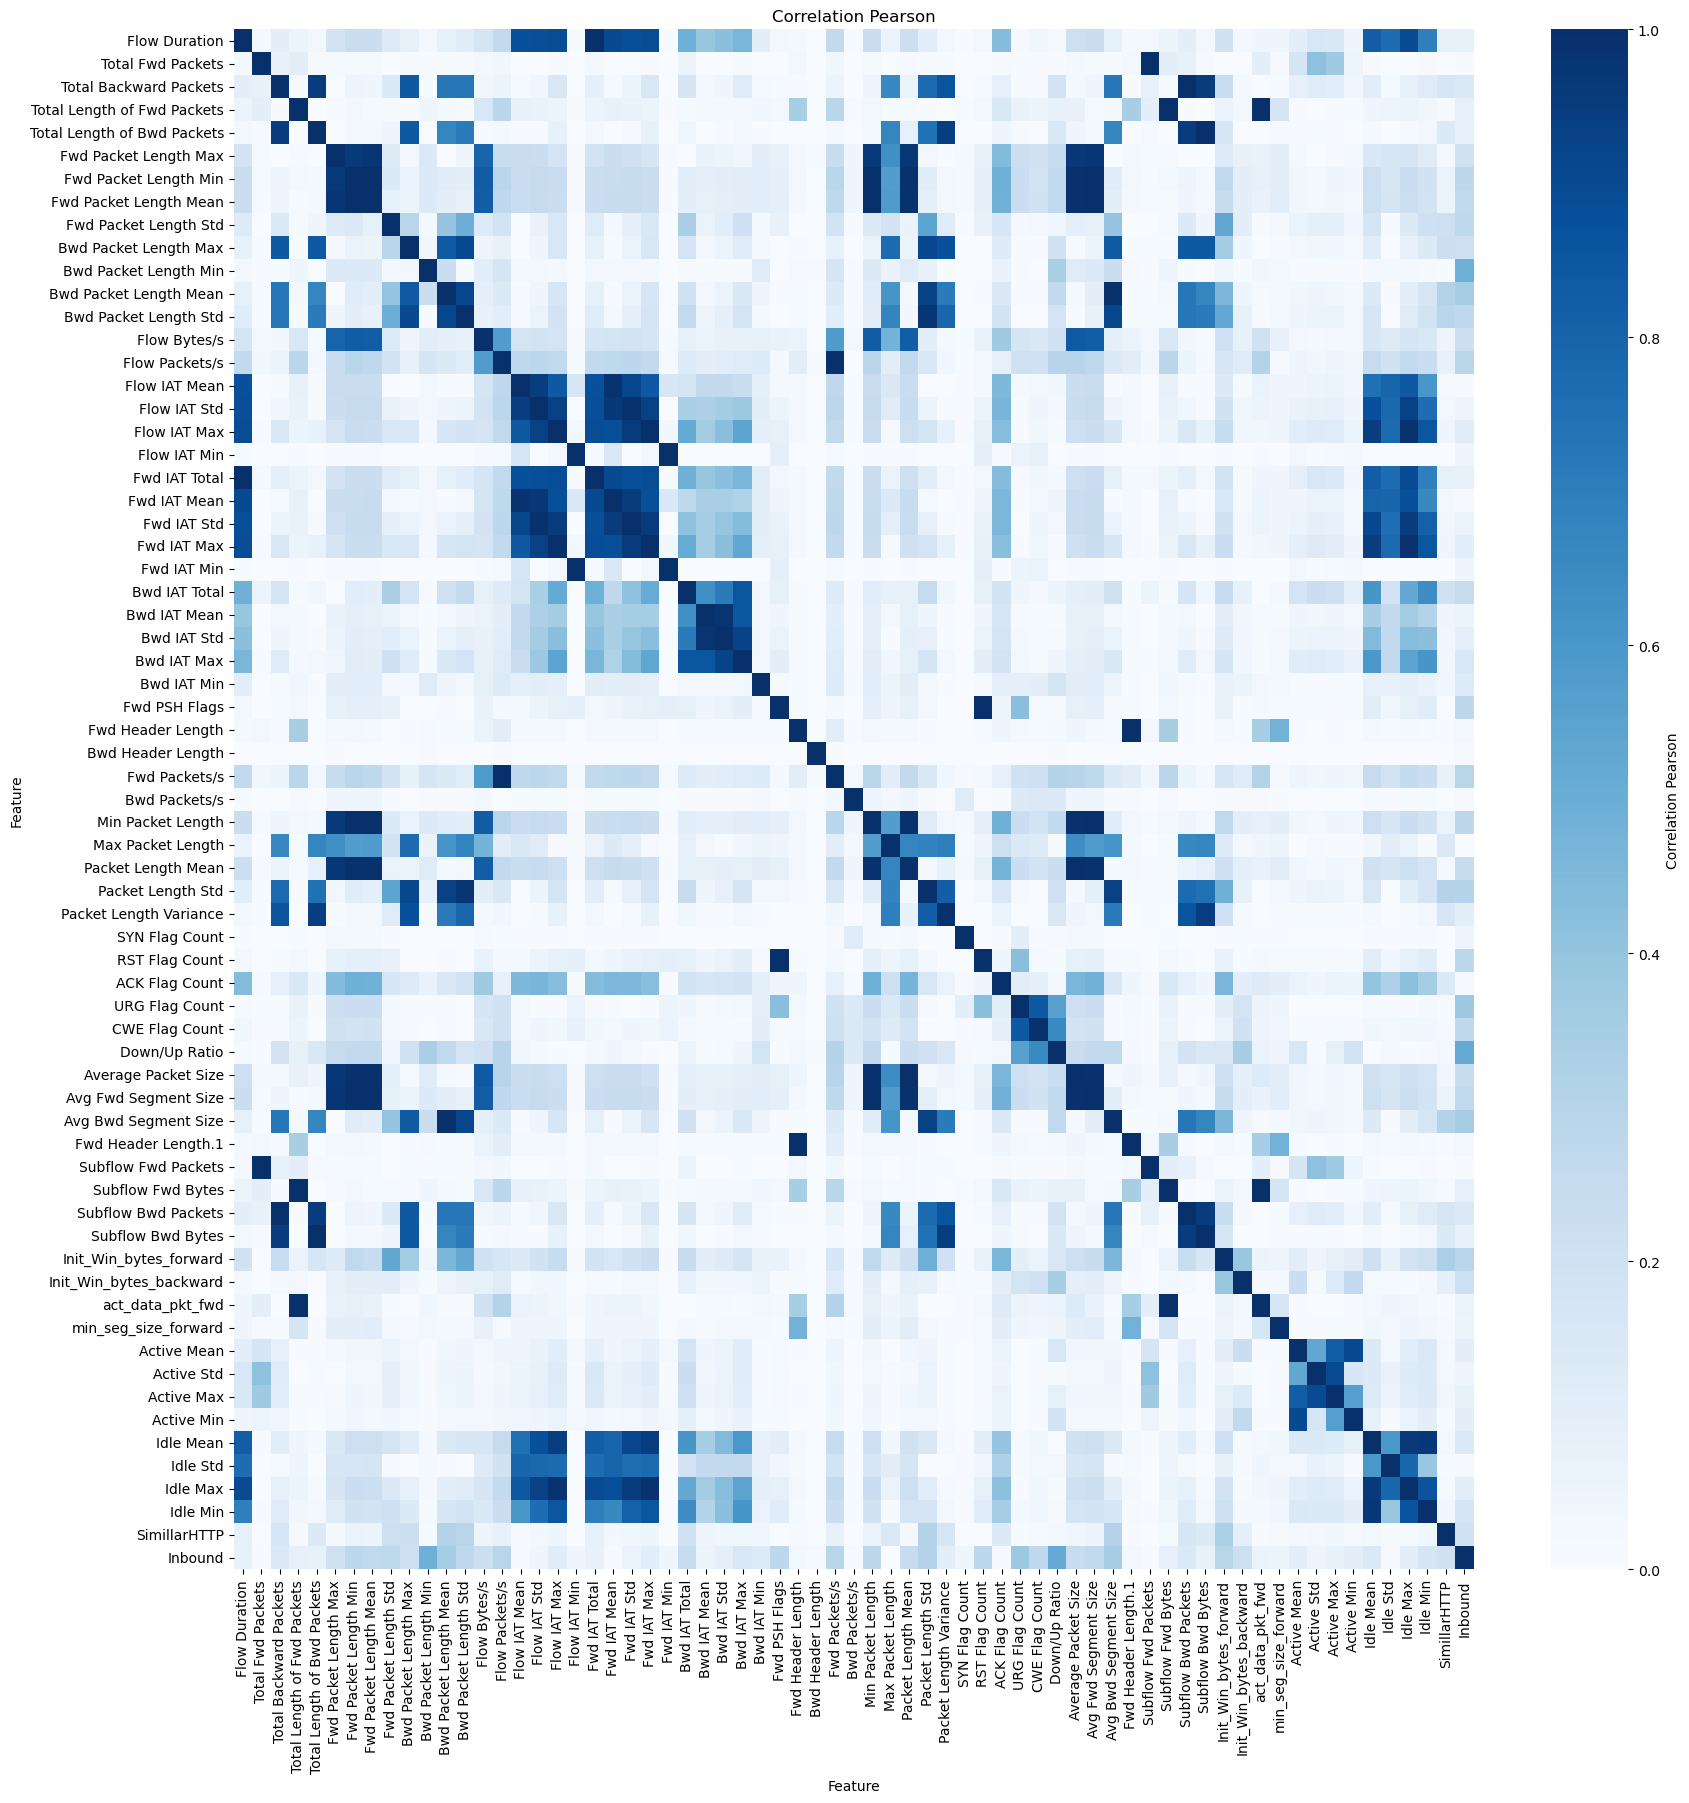

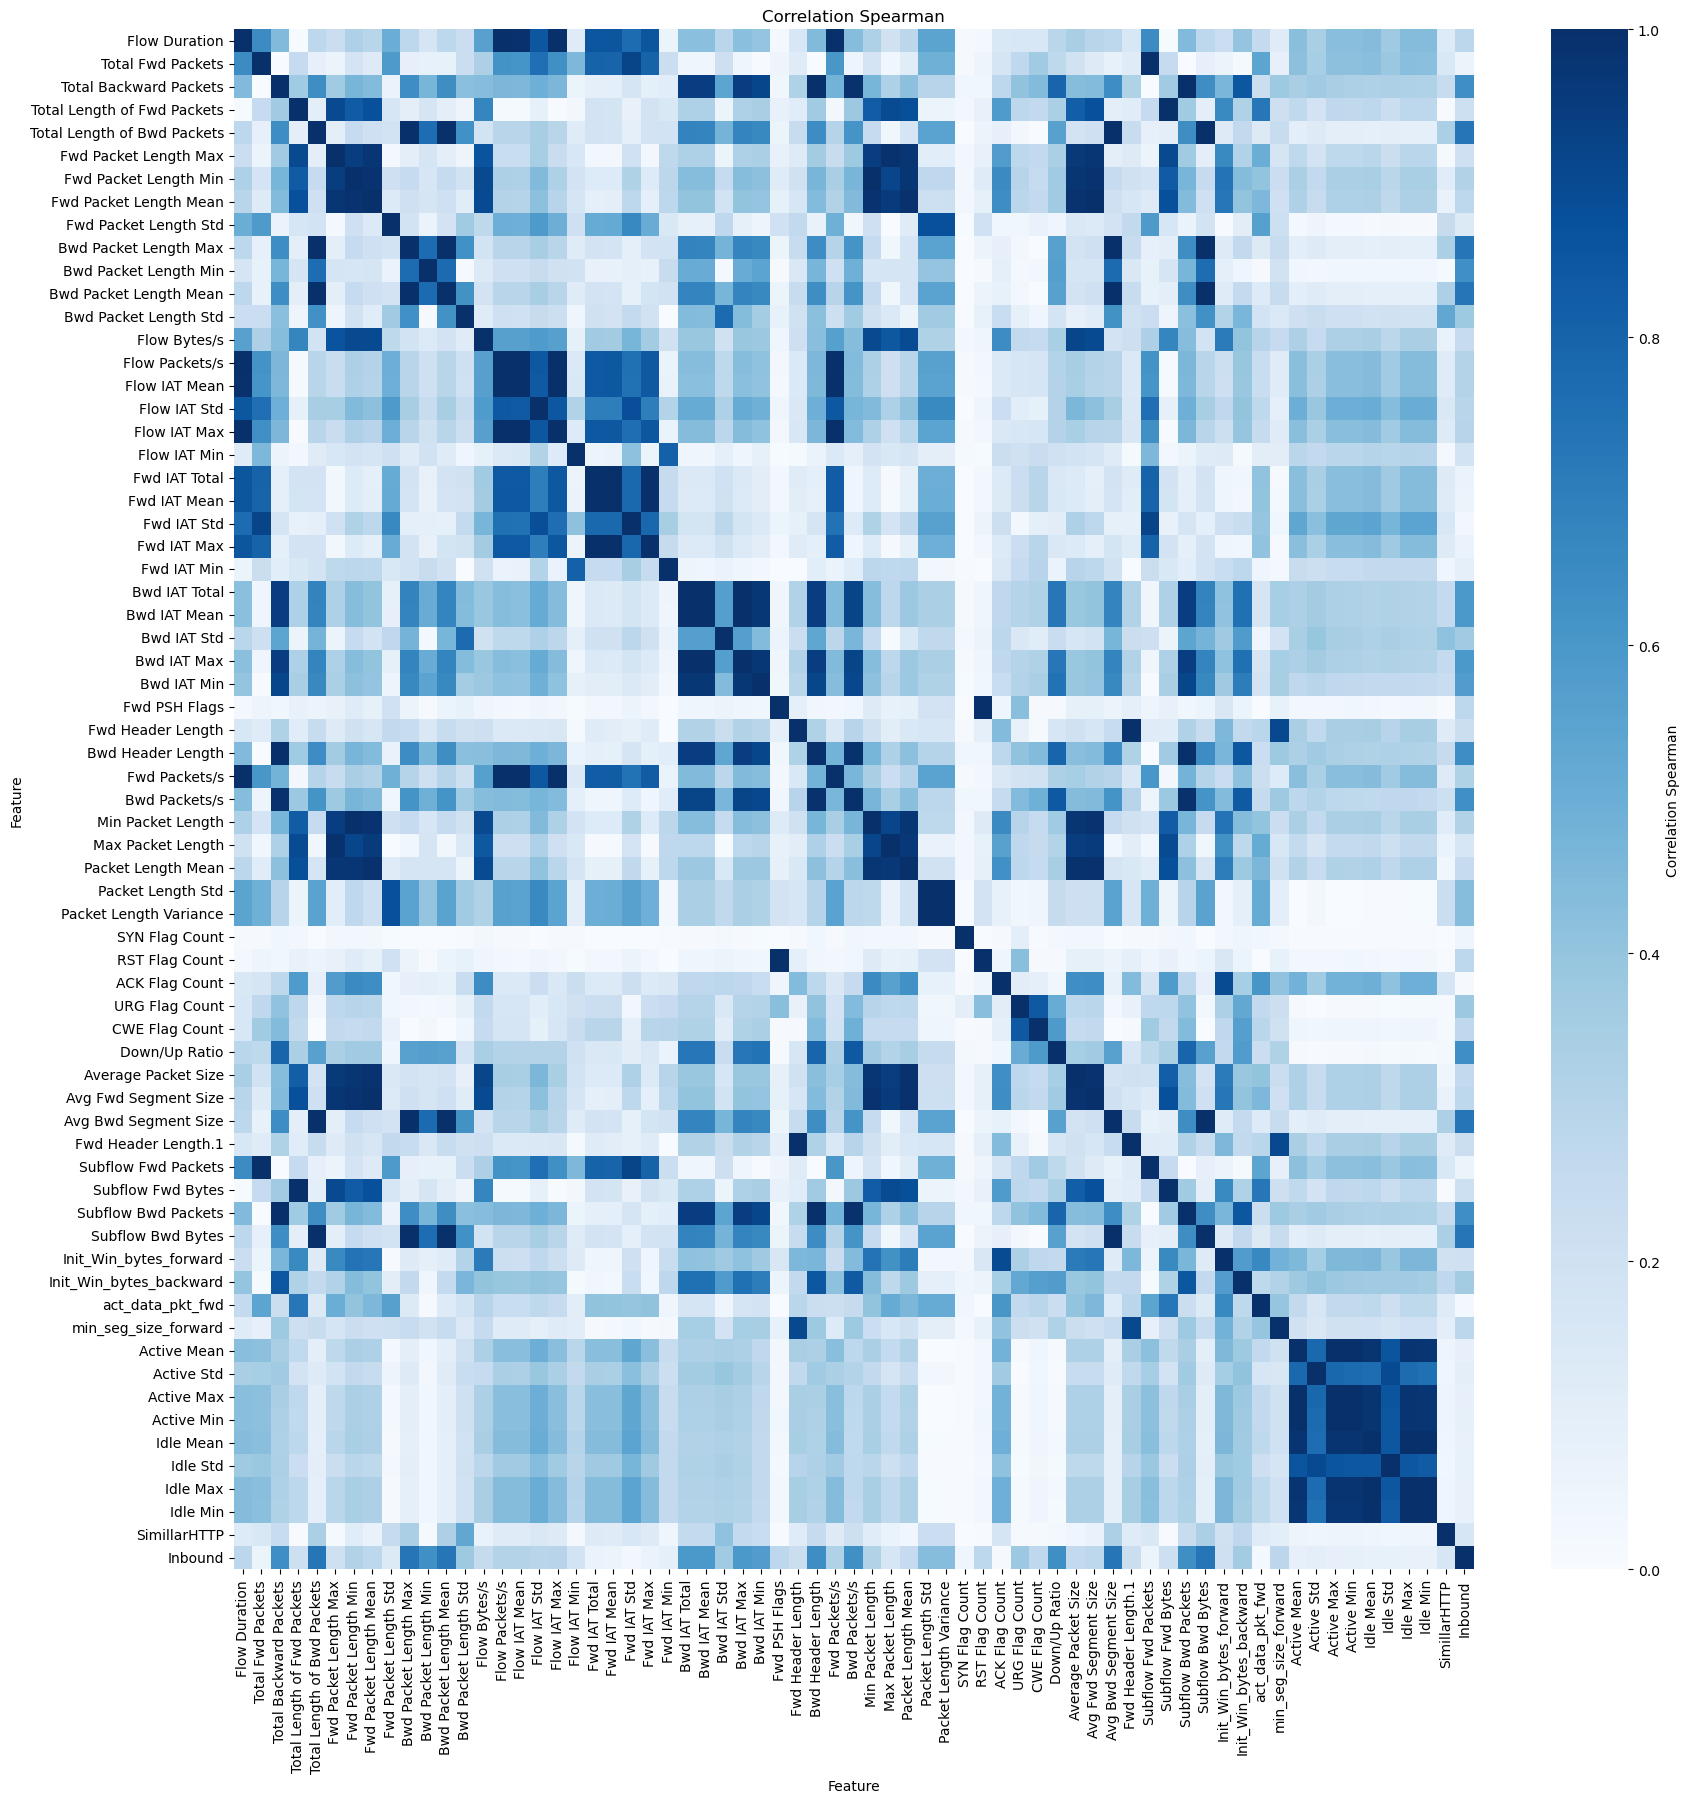

In [58]:
correlation_matrix_pearson = ddos_data_s.corr(method='pearson').abs()
correlation_matrix_spearman = ddos_data_s.corr(method='spearman').abs()

# correlation pearson matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_pearson, cmap='Blues', vmin=.0, vmax=1, cbar_kws={'label': 'Correlation Pearson'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Pearson')
plt.show()

# correlation spearman matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix_spearman, cmap='Blues', vmin=.0, vmax=1, cbar_kws={'label': 'Correlation Spearman'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Spearman')
plt.show()

## Feature selection

The aim is to remove features that are highly correlated with each other, as such features can lead to redundancy and multicollinearity problems in models. The columns related to these features will be dropped in the other notebooks of the project.

In [61]:
# Extract features having a correlation > 0.85
c = correlation_matrix_pearson[correlation_matrix_pearson > 0.85]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull() == False) & (so["level_0"] != so["level_1"])]
to_be_deleted_pearson = []
candidates = list(so["level_0"])

# Get the unique set of features to be deleted
# Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted_pearson.append(candidate)  # add the feature to the removed candidates
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (
                    subset_so["level_1"] != candidate)]  # remove the rows that the removed feature is involved

print(len(to_be_deleted_pearson), 'features to be removed')
print(sorted(to_be_deleted_pearson))

37 features to be removed
['Active Mean', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packets/s', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']


In [62]:
# Extract features having a correlation > 0.85
c = correlation_matrix_spearman[correlation_matrix_spearman > 0.85]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull() == False) & (so["level_0"] != so["level_1"])]
to_be_deleted_spearman = []
candidates = list(so["level_0"])

# Get the unique set of features to be deleted
# Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted_spearman.append(candidate)  # add the feature to the removed candidates
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (
                    subset_so["level_1"] != candidate)]  # remove the rows that the removed feature is involved

print(len(to_be_deleted_spearman), 'features to be removed')
print(sorted(to_be_deleted_spearman))

43 features to be removed
['Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Total', 'Bwd Packet Length Mean', 'Bwd Packets/s', 'Flow Duration', 'Flow IAT Mean', 'Flow Packets/s', 'Fwd Header Length', 'Fwd Header Length.1', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd PSH Flags', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packets/s', 'Idle Max', 'Idle Mean', 'Init_Win_bytes_forward', 'Max Packet Length', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Fwd Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']


In [63]:
# Converti le liste in set
set_pearson = set(to_be_deleted_pearson)
set_spearman = set(to_be_deleted_spearman)

# Trova gli elementi presenti in lista1 ma non in lista2
mancanti_in_spearman = set_pearson - set_spearman

# Trova gli elementi presenti in lista2 ma non in lista1
mancanti_in_pearson = set_spearman - set_pearson

print("Elementi mancanti in spearman:", mancanti_in_spearman)
print("Elementi mancanti in pearson:", mancanti_in_pearson)

Elementi mancanti in spearman: {'Fwd IAT Min', 'Flow IAT Std', 'RST Flag Count', 'Flow IAT Max', 'Bwd Packet Length Std', 'Bwd IAT Std'}
Elementi mancanti in pearson: {'Init_Win_bytes_forward', 'Total Fwd Packets', 'Bwd IAT Total', 'Fwd Header Length.1', 'Flow Packets/s', 'Bwd Header Length', 'Fwd PSH Flags', 'Fwd Packet Length Max', 'Active Min', 'Active Max', 'Max Packet Length', 'Bwd Packets/s'}


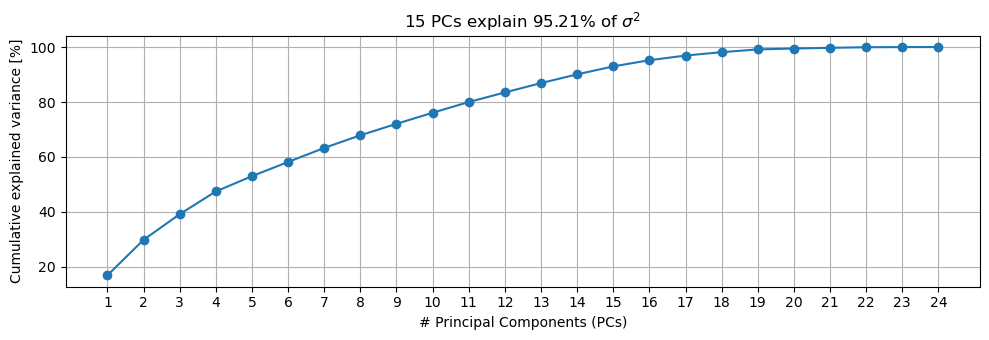

In [44]:
pca = PCA(random_state=15) # initialize PCA
pca.fit(ddos_data_x) # Fit the PCA on the entire dataset
explained_variance = pca.explained_variance_ratio_ # Get the explained variance
cumul_exp_var = np.cumsum(explained_variance) # Get the cumulative explained variance
perc_cumul_exp_var = cumul_exp_var*100 # Get the percentages

# Plot
plt.figure(figsize=(10, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks(np.arange(0, 24, 1), np.arange(1, 25, 1))
plt.grid()
plt.title(f'15 PCs explain {round(perc_cumul_exp_var[15], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

Abbiamo scelto di seguire la seguente strategia:
1)  eseguire la PCA sull'intero dataset
2)  calolcare la matrice di correlazione con coefficente di pearson
3)  calcolare la matrice di correlazione con coefficente di spearman
4)  valutare i risultati evinti da loading score e dai coefficenti per scegliere le features da eliminare

Abbiamo provato entrambi i coefficenti di correlazione perchè non sappiamo se ci troveremo di fronte a relazioni lineari o non lineari, quindi vogliamo cercare di essere il più generici possibili per ora ed esplorare entrambe le vie.

Siamo consapevoli che questo renderà la PCA meno efficace nel ridurre la dimensionalità visto che il dataset include molte features altamente correlate, ma questo ci assicura di non eliminare subito features che, nonostante l'alta correlazione, sono critiche per catturare aspetti unici dei dati.